!pip install -U ydata-profiling

In [154]:
# Import Libraries
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, auc, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


In [155]:
df = pd.read_csv('final_project.csv')

In [170]:
def load_and_prepare_data(file_path='final_project.csv'):
    """
    Load the telecommunications customer churn dataset and perform initial preprocessing.
    """
    try:
        # Load the dataset
        df = pd.read_csv(file_path)

        # Convert 'TotalCharges' to numeric (may contain invalid strings)
        if 'TotalCharges' in df.columns:
            df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

        # Handle missing values
        numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
        categorical_cols = df.select_dtypes(include=['object']).columns

        # Impute missing numerical values
        if len(numerical_cols) > 0:
            num_imputer = SimpleImputer(strategy='median')
            df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

        # Impute missing categorical values
        if len(categorical_cols) > 0:
            cat_imputer = SimpleImputer(strategy='most_frequent')
            df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

        # Encode target variable (example assumes 'Churn' is the target)
        if 'Churn' in df.columns:
            df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

        return df
        # return df
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

In [172]:
load_and_prepare_data('final_project.csv')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0.0,Yes,No,1.0,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0.0,No,No,34.0,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0.0,No,No,2.0,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0.0,No,No,45.0,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0.0,No,No,2.0,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0.0,Yes,Yes,24.0,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0
7039,2234-XADUH,Female,0.0,Yes,Yes,72.0,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0
7040,4801-JZAZL,Female,0.0,Yes,Yes,11.0,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0
7041,8361-LTMKD,Male,1.0,Yes,No,4.0,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1


In [ ]:
def generate_eda_report(df, filename='eda_report.html'):
    profile = ProfileReport(df, title="EDA Report", explorative=True)
    profile.to_file(filename)
    print(f"EDA Report saved to {filename}")
    profile.to_notebook_iframe()

generate_eda_report(df, filename='eda_report.html')

In [158]:
def engineer_features(df):
    """
    Engineer features directly on existing columns without adding new ones.
    """
    # Convert 'TotalCharges' to numeric, replacing errors with NaN
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

    # # Encode 'InternetService' where NaN indicates 'No internet service'
    # df['InternetService'] = df['InternetService'].fillna('No internet service')
    df['InternetService'] = df['InternetService'].map({'Fiber optic': 1, 'DSL': 2, 'No internet service': 0})

    # Encode categorical columns as numeric
    df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
    df['Partner'] = df['Partner'].map({'Yes': 1, 'No': 0})
    df['Dependents'] = df['Dependents'].map({'Yes': 1, 'No': 0})
    df['PhoneService'] = df['PhoneService'].map({'Yes': 1, 'No': 0})
    df['MultipleLines'] = df['MultipleLines'].map({'Yes': 1, 'No': 0, 'No phone service': 0})
    df['OnlineSecurity'] = df['OnlineSecurity'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
    df['OnlineBackup'] = df['OnlineBackup'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
    df['DeviceProtection'] = df['DeviceProtection'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
    df['TechSupport'] = df['TechSupport'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
    df['StreamingTV'] = df['StreamingTV'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
    df['StreamingMovies'] = df['StreamingMovies'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
    df['Contract'] = df['Contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})
    df['PaperlessBilling'] = df['PaperlessBilling'].map({'Yes': 1, 'No': 0})
    df['PaymentMethod'] = df['PaymentMethod'].map({'Electronic check': 0, 'Mailed check': 1, 'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3})
    # Convert 'Churn' to numeric
    if 'Churn' in df.columns:
        df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

    # Create 'TotalChargesPerMonth' directly by dividing 'TotalCharges' by 'tenure'
    df['TotalChargesPerMonth'] = df['TotalCharges'] / (df['tenure'] + 1e-10)

    # Drop 'customerID' as it's not needed for training
    if 'customerID' in df.columns:
        df.drop(['customerID'], axis=1, inplace=True)

    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Apply Min-Max scaling to all columns except 'Churn' (target)
    columns_to_scale = df.columns[df.columns != 'Churn']
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

    return df


In [159]:
engineer_features(df)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalChargesPerMonth
0,0.0,0.0,1.0,0.0,0.013889,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.000000,0.115423,0.001275,0,0.149361
1,1.0,0.0,0.0,0.0,0.472222,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.333333,0.385075,0.215867,0,0.388372
2,1.0,0.0,0.0,0.0,0.027778,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.333333,0.354229,0.010310,1,0.374448
3,1.0,0.0,0.0,0.0,0.625000,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.5,0.0,0.666667,0.239303,0.210241,0,0.252084
4,0.0,0.0,0.0,0.0,0.027778,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.000000,0.521891,0.015330,1,0.576539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.0,0.0,1.0,1.0,0.333333,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.5,1.0,0.333333,0.662189,0.227521,0,0.642625
7039,0.0,0.0,1.0,1.0,1.000000,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.5,1.0,1.000000,0.845274,0.847461,0,0.822184
7040,0.0,0.0,1.0,1.0,0.152778,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.000000,0.112935,0.037809,0,0.164650
7041,1.0,1.0,1.0,0.0,0.055556,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.333333,0.558706,0.033210,1,0.584204


In [160]:
def select_features(df):
    """
    Select relevant features using correlation analysis and feature importance.

    Parameters:
    - df (DataFrame): The preprocessed dataset.

    Returns:
    - list: List of selected feature names.
    """

    # Encode categorical variables
    df_encoded = df.copy()
    label_encoder = LabelEncoder()

    for col in df_encoded.select_dtypes(include=['object']).columns:
        df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

    # Compute correlation with 'Churn'
    corr_matrix = df_encoded.corr()
    target_corr = corr_matrix['Churn'].abs().sort_values(ascending=False)
    print("\nCorrelation with Churn:")
    print(target_corr)

    # Select features with high correlation to Churn (threshold: 0.1)
    correlated_features = target_corr[target_corr > 0.1].index.tolist()

    # Use DecisionTreeClassifier to calculate feature importance
    X = df_encoded.drop('Churn', axis=1)
    y = df_encoded['Churn']
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X, y)
    feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("\nFeature Importances:")
    print(feature_importances)

    # Combine correlation and importance
    all_selected_features = set(correlated_features).intersection(feature_importances[feature_importances > 0.01].index)
    print("\nSelected Features:")
    return list(all_selected_features)  # Return the selected features


In [161]:
select_features(df)


Correlation with Churn:
Churn                   1.000000
Contract                0.396713
tenure                  0.352229
PaymentMethod           0.262818
InternetService         0.244319
TotalCharges            0.199484
MonthlyCharges          0.193356
TotalChargesPerMonth    0.192033
PaperlessBilling        0.191825
OnlineSecurity          0.171226
TechSupport             0.164674
Dependents              0.164221
SeniorCitizen           0.150889
Partner                 0.150448
OnlineBackup            0.082255
DeviceProtection        0.066160
StreamingTV             0.063228
StreamingMovies         0.061382
MultipleLines           0.040102
PhoneService            0.011942
gender                  0.008612
Name: Churn, dtype: float64

Feature Importances:
Contract                0.169744
MonthlyCharges          0.157772
TotalChargesPerMonth    0.148045
TotalCharges            0.143556
tenure                  0.108570
InternetService         0.049150
PaymentMethod           0.039198
g

['TotalCharges',
 'Partner',
 'SeniorCitizen',
 'tenure',
 'Contract',
 'PaymentMethod',
 'PaperlessBilling',
 'InternetService',
 'TechSupport',
 'MonthlyCharges',
 'Dependents',
 'OnlineSecurity',
 'TotalChargesPerMonth']

In [162]:
def visualize_decision_tree(df, target='Churn'):
    """
    Visualizes the decision tree for feature selection.

    Parameters:
    - df (DataFrame): Preprocessed dataset.
    - target (str): Target column for the decision tree.
    """
    # Encode categorical variables
    df_encoded = df.copy()
    label_encoder = LabelEncoder()
    for col in df_encoded.select_dtypes(include=['object']).columns:
        df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

    # Split features and target
    X = df_encoded.drop(target, axis=1)
    y = df_encoded[target]

    # Train a decision tree classifier
    model = DecisionTreeClassifier(random_state=42, max_depth=5)
    model.fit(X, y)

    # Visualize the decision tree
    plt.figure(figsize=(20, 10))
    plot_tree(
        model,
        feature_names=X.columns,
        class_names=['No', 'Yes'],  # Replace with actual target labels if available
        filled=True,
        rounded=True,
        fontsize=10
    )
    plt.title("Decision Tree Visualizing Feature Selection")
    plt.show()


In [163]:
def finalized_features(df, target='Churn'):
    """
    Use a decision tree to finalize the dataset by selecting the most informative features.

    Parameters:
    - df (DataFrame): Preprocessed dataset.
    - target (str): Target column for the decision tree.

    Returns:
    - list: List of selected feature names based on feature importance.
    """
    # Encode categorical variables
    df_encoded = df.copy()
    label_encoder = LabelEncoder()
    for col in df_encoded.select_dtypes(include=['object']).columns:
        df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

    # Split features and target
    X = df_encoded.drop(target, axis=1)
    y = df_encoded[target]

    # Train a decision tree classifier
    model = DecisionTreeClassifier(random_state=42, max_depth=5)
    model.fit(X, y)

    # Calculate feature importances
    feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    # print("\nFeature Importances from Decision Tree:")
    # print(feature_importances)

    # Select features with non-zero importance
    selected_features = feature_importances[feature_importances > 0].index.tolist()
    selected_features_plus_target = selected_features + [target]

    return df_encoded[selected_features_plus_target], df[selected_features]  # Return the list of selected feature names



Final Selected Features:
['Contract', 'tenure', 'InternetService', 'MonthlyCharges', 'TotalCharges', 'TotalChargesPerMonth', 'PaymentMethod', 'PhoneService', 'StreamingMovies', 'TechSupport', 'SeniorCitizen']


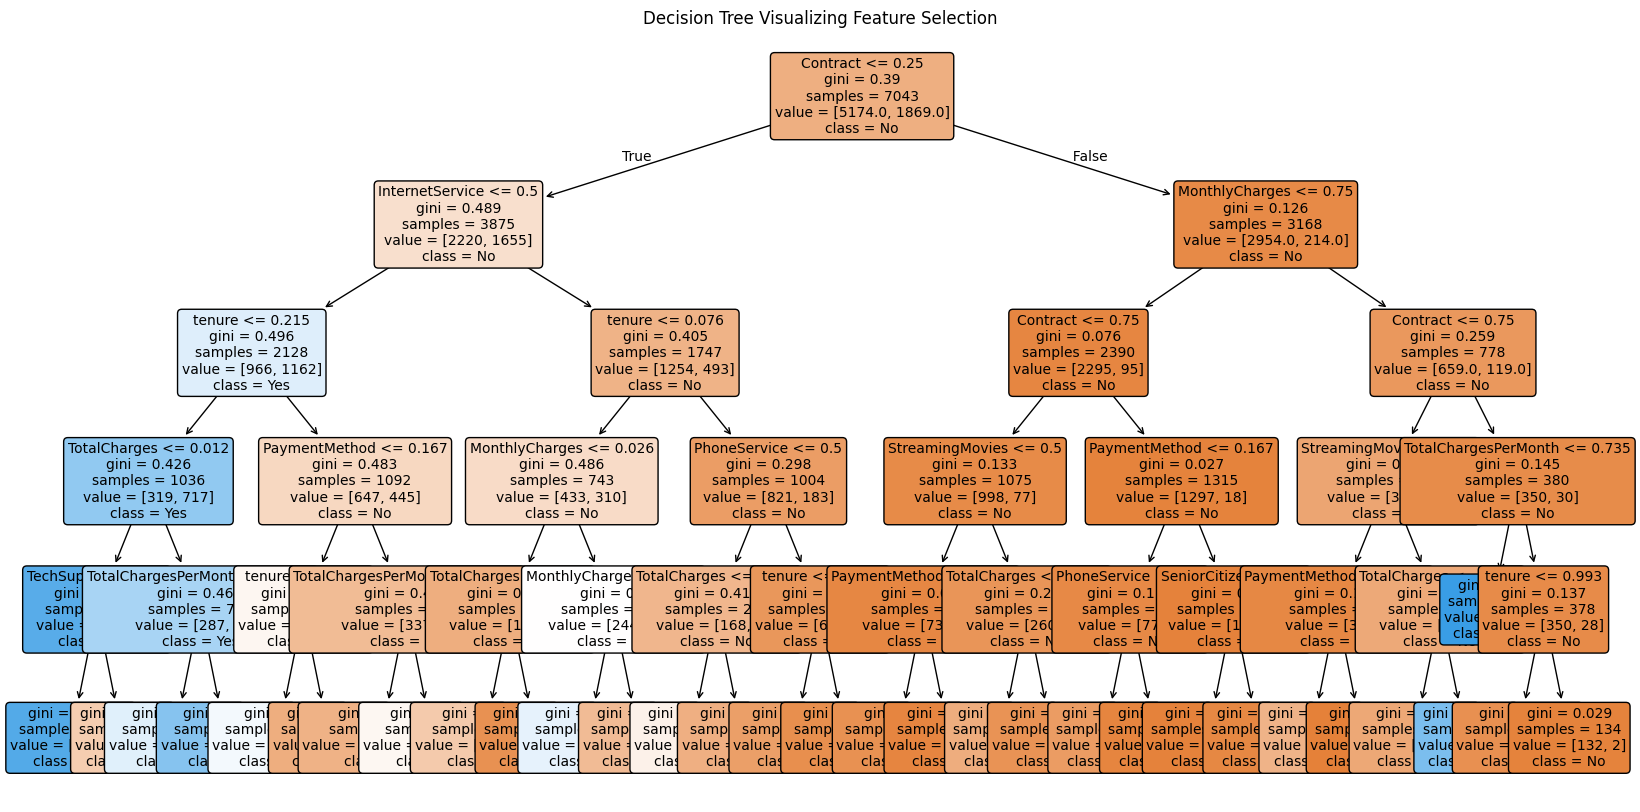

In [164]:
# Assuming finalized_df is already the DataFrame with selected features
finalized_df_target, finalized_df = finalized_features(df, target='Churn')

# Extract the selected feature names into a DataFrame
selected_features = finalized_df.columns.tolist()

# Display the resulting DataFrame
print(f"\nFinal Selected Features:")
print(selected_features)

visualize_decision_tree(df, target='Churn')

In [165]:
# Function to preprocess data (encoding, scaling)
def preprocess_data(df, features):
    # Encoding categorical variables
    df_encoded = df.copy()
    label_encoder = LabelEncoder()

    # Ensure that 'Churn' is encoded as well if it's categorical
    if df_encoded['Churn'].dtype == 'object':
        df_encoded['Churn'] = label_encoder.fit_transform(df_encoded['Churn'])

    # Encode all other categorical columns
    for col in df_encoded.select_dtypes(include=['object']).columns:
        if col != 'Churn':  # Avoid encoding 'Churn' again
            df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

    # Standardizing the features
    X = df_encoded[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return pd.DataFrame(X_scaled, columns=features)

# Function to preprocess data (standardization)
def preprocess_for_clustering(df):
    df = engineer_features(df)

    features = selected_features  # Use the feature selection function from previous code
    df_scaled = preprocess_data(df, features)  # Preprocess the data (encoding, scaling)

    # Retain the 'Churn' column for later use
    df_scaled['Churn'] = df['Churn'].copy()  # Ensure Churn is available for evaluation

    # Standardize the features
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled.drop('Churn', axis=1)), columns=df_scaled.drop('Churn', axis=1).columns)

    # Add 'Churn' column back to the scaled data
    df_scaled['Churn'] = df['Churn'].copy()

    return df_scaled


In [166]:
# Function to determine the optimal number of clusters using the Elbow Method
def find_optimal_clusters(df_scaled, max_clusters=10):
    inertia = []  # List to store the inertia values for each number of clusters
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df_scaled)
        inertia.append(kmeans.inertia_)

    # Plot the Elbow Curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_clusters + 1), inertia, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show()

In [167]:
# Function to perform clustering and calculate silhouette score
def kmeans_clustering(df_scaled, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    # df_scaled['Cluster'] = kmeans.fit_predict(df_scaled)
    df_scaled['Cluster'] = kmeans.fit_predict(df_scaled.drop('Churn', axis=1))  # Drop 'Churn' for clustering

        # Match cluster labels with actual labels (using the most common label in each cluster)
    df_scaled['Predicted_Label'] = df_scaled.groupby('Cluster')['Churn'].transform(lambda x: x.mode()[0])

    true_labels = df_scaled['Churn']
    # label_encoder.transform(df_scaled['Churn'])  # Encode 'Churn' to numeric values for evaluation

    # Metrics Calculation
    accuracy = accuracy_score(true_labels, df_scaled['Predicted_Label'])
    precision = precision_score(true_labels, df_scaled['Predicted_Label'], average='binary', zero_division=0)
    recall = recall_score(true_labels, df_scaled['Predicted_Label'], average='binary', zero_division=0)
    f1 = f1_score(true_labels, df_scaled['Predicted_Label'], average='binary', zero_division=0)

    # For AUC-ROC, use cluster probabilities or predicted labels
    auc_roc = None
    if len(np.unique(true_labels)) == 2:  # Binary classification (0 or 1)
        auc_roc = roc_auc_score(true_labels, df_scaled['Predicted_Label'])
        fpr, tpr, thresholds = roc_curve(true_labels, df_scaled['Predicted_Label'])


    # Display metrics
    print(f"\nClustering Evaluation Metrics for {n_clusters} Clusters:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}" if auc_roc is not None else "AUC-ROC: Not applicable (multi-class)")

    # Calculate silhouette score
    silhouette_avg = silhouette_score(df_scaled, df_scaled['Cluster'])
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg:.4f}")

    return df_scaled, kmeans

In [168]:
# Function to visualize clusters using PCA (if high-dimensional data)
def visualize_clusters(df_scaled, kmeans, n_components=2):
    # Reduce dimensions using PCA
    pca = PCA(n_components=n_components)
    pca_components = pca.fit_transform(df_scaled.drop('Cluster', axis=1))  # Drop 'Cluster' for PCA

    # Add PCA components to the dataframe
    df_scaled['PCA1'] = pca_components[:, 0]
    df_scaled['PCA2'] = pca_components[:, 1]

    # Plot the clusters in 2D
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_scaled, palette='Set1', s=100, alpha=0.7)
    plt.title('Clusters Visualized using PCA')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Cluster')
    plt.show()

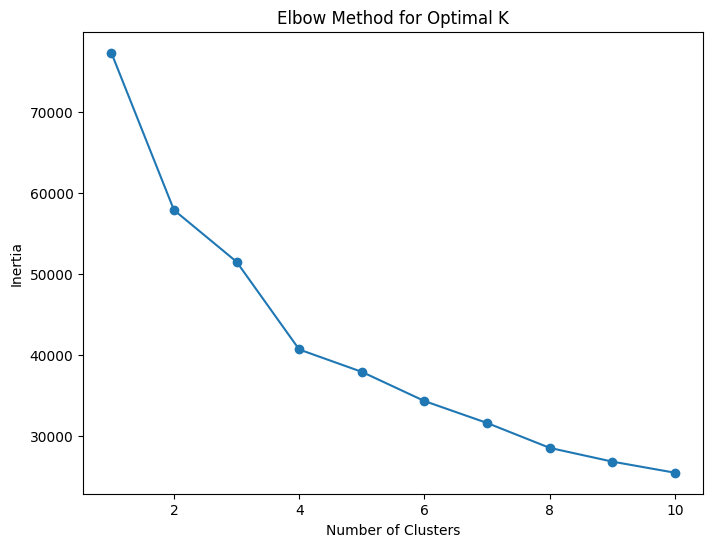


Clustering Evaluation Metrics for 2 Clusters:
Accuracy: 0.7346
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC-ROC: 0.5000
Silhouette Score for 2 clusters: 0.2580


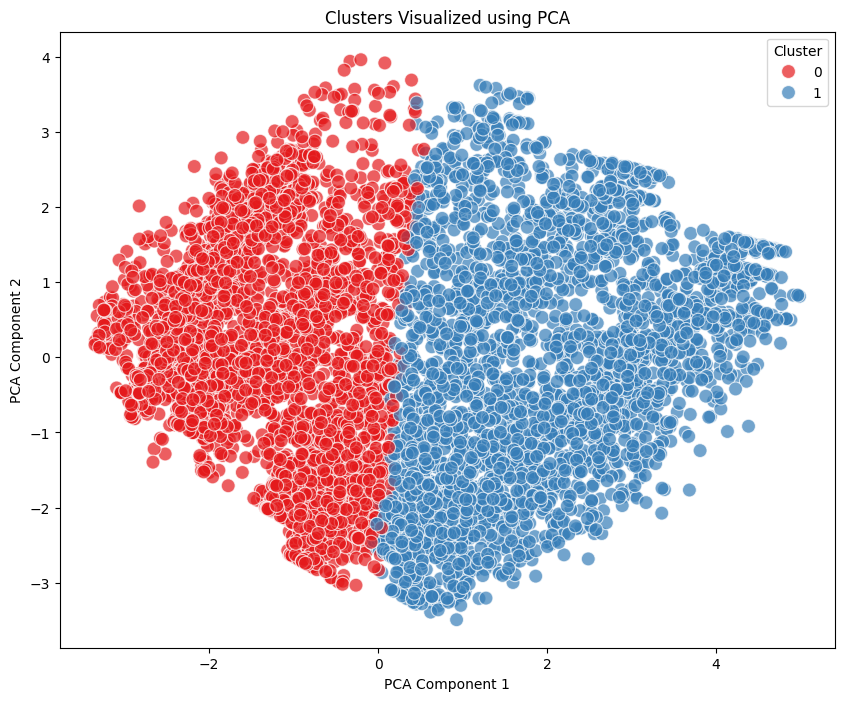

In [169]:
df = pd.read_csv('final_project.csv')

# Preprocess the data
df_scaled = preprocess_for_clustering(df)

# Double-check for NaNs after preprocessing
df_scaled.fillna(df_scaled.mean(numeric_only=True), inplace=True)

find_optimal_clusters(df_scaled, max_clusters=10)

# Perform Clustering
df_scaled_with_clusters, kmeans_model = kmeans_clustering(df_scaled, n_clusters=2)

# Visualize the Clusters using PCA
visualize_clusters(df_scaled_with_clusters, kmeans_model, n_components=2)

In [ ]:
def logistic_regression(df_scaled_with_clusters, selected_features_df):
    """
    Perform Logistic Regression on the dataset using selected features and evaluate performance.

    Parameters:
    - df_scaled_with_clusters (DataFrame): The preprocessed dataset with clustering and features.
    - selected_features (list): List of selected features to use in the model.

    Returns:
    - None: The function prints the evaluation metrics and visualizations.
    """
    # Prepare the dataset with selected features
    X = df_scaled_with_clusters[selected_features]  # Features
    y = df_scaled_with_clusters['Churn']  # Target variable

    # Split the dataset into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the data (optional, but recommended for Logistic Regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train the Logistic Regression model
    logreg_model = LogisticRegression(random_state=42)
    logreg_model.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = logreg_model.predict(X_test_scaled)
    y_pred_prob = logreg_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    # Print the metrics
    print("Logistic Regression Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")

    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # ROC Curve Plot
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label="Random classifier")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()


In [ ]:
df = pd.read_csv('final_project.csv')

logistic_regression(df_scaled_with_clusters, selected_features)

In [ ]:
def evaluate_svm(df, target='Churn'):
    """
    Train an SVM classifier and evaluate it using various metrics (accuracy, precision, recall, F1 score, AUC-ROC).

    Parameters:
    - df (DataFrame): The dataset containing features and target column.
    - target (str): The name of the target column in the dataset (default is 'Churn').

    Prints the evaluation metrics and displays the ROC curve.
    """
    # Ensure selected features include the target column for evaluation
    selected_features_df, selected_features = finalized_features(df, target=target)

    # Split the data into features (X) and target (y)
    X = selected_features_df.drop(columns=[target])
    y = selected_features_df[target]

    # Split data into training and test sets (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Standardize the features (SVM is sensitive to feature scaling)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create and train the SVM model
    svm_model = SVC(probability=True, random_state=42)  # 'probability=True' for AUC-ROC calculation
    svm_model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = svm_model.predict(X_test_scaled)
    y_pred_prob = svm_model.predict_proba(X_test_scaled)[:, 1]  # Probability scores for ROC curve

    # Calculate accuracy, precision, recall, f1-score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate AUC-ROC score
    auc_roc = roc_auc_score(y_test, y_pred_prob)

    # Print the evaluation metrics
    print("Evaluation Metrics: ")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # ROC Curve plotting
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random chance line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')



In [ ]:
df = pd.read_csv('final_project.csv')
evaluate_svm(df, target='Churn')

In [ ]:
def evaluate_nn(df, target='Churn'):
    """
    Train a Neural Network (MLPClassifier) and evaluate it using accuracy, precision, recall, f1-score, and AUC-ROC.
    It also plots the ROC curve and decision boundary.

    Parameters:
    - df (DataFrame): The dataset containing features and target column.
    - target (str): The name of the target column in the dataset (default is 'Churn').
    """
    # Feature selection and encoding
    selected_features_df, selected_features = finalized_features(df, target=target)

    # Split features and target
    X = selected_features_df.drop(columns=[target])
    y = selected_features_df[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Neural Network (MLPClassifier)
    nn_model = MLPClassifier(hidden_layer_sizes=(100,), random_state=42, max_iter=2000)
    nn_model.fit(X_train_scaled, y_train)

    # Evaluate the model
    y_pred = nn_model.predict(X_test_scaled)
    y_pred_prob = nn_model.predict_proba(X_test_scaled)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_prob)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # ROC Curve plotting
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random chance line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
df = pd.read_csv('final_project.csv')

evaluate_nn(df, target='Churn')

In [ ]:
def evaluate_random_forest(df, target='Churn'):
    """
    Train a Random Forest classifier and evaluate it using various metrics (accuracy, precision, recall, F1 score, AUC-ROC).

    Parameters:
    - df (DataFrame): The dataset containing features and target column.
    - target (str): The name of the target column in the dataset (default is 'Churn').

    Prints the evaluation metrics and displays the ROC curve.
    """
    # Get the selected features and the target from finalized_features function
    selected_features_df, selected_features = finalized_features(df, target=target)

    # Split the data into features (X) and target (y)
    X = selected_features_df.drop(columns=[target])
    y = selected_features_df[target]

    # Split data into training and test sets (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Standardize the features (Random Forest isn't very sensitive to scaling, but it's good practice)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create and train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test_scaled)
    y_pred_prob = rf_model.predict_proba(X_test_scaled)[:, 1]  # Probability scores for ROC curve

    # Calculate accuracy, precision, recall, f1-score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate AUC-ROC score
    auc_roc = roc_auc_score(y_test, y_pred_prob)

    # Print the evaluation metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    # ROC Curve plotting
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random chance line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
df = pd.read_csv('final_project.csv')

evaluate_random_forest(df, target='Churn')

In [ ]:
def best_model(df, target='Churn'):
    """
    Evaluate multiple machine learning models and return the overall best model
    by considering multiple performance metrics.

    Parameters:
    - df (DataFrame): The dataset containing features and target column
    - target (str): The name of the target column (default is 'Churn')

    Returns:
    - dict: A dictionary containing model performance metrics and the best model
    """
    # Prepare the dataset
    selected_features_df, selected_features = finalized_features(df, target=target)

    # Split features and target
    X = selected_features_df.drop(columns=[target])
    y = selected_features_df[target]

    # Prepare train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42),
        'Support Vector Machine': SVC(probability=True, random_state=42),
        'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), random_state=42, max_iter=2000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
    }

    # Dictionary to store model performance
    model_performance = {}

    # Evaluate each model
    for name, model in models.items():
        # Train the model
        model.fit(X_train_scaled, y_train)

        # Predictions
        y_pred = model.predict(X_test_scaled)
        y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

        # Calculate metrics
        performance = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'AUC-ROC': roc_auc_score(y_test, y_pred_prob)
        }

        model_performance[name] = performance

        # Print model performance
        print(f"\n{name} Performance:")
        for metric_name, value in performance.items():
            print(f"{metric_name}: {value:.4f}")

    # Function to calculate an overall score
    def calculate_overall_score(metrics):
        """
        Calculate an overall score by normalizing and averaging key metrics.
        Gives slightly more weight to AUC-ROC and F1-Score.
        """
        # Normalize each metric to a 0-1 scale
        normalized_metrics = {
            'Accuracy': metrics['Accuracy'],
            'Precision': metrics['Precision'],
            'Recall': metrics['Recall'],
            'F1-Score': metrics['F1-Score'],
            'AUC-ROC': metrics['AUC-ROC']
        }

        # Calculate weighted average
        # Giving slightly more weight to AUC-ROC and F1-Score
        overall_score = (
            normalized_metrics['AUC-ROC'] * 0.3 +
            normalized_metrics['F1-Score'] * 0.25 +
            normalized_metrics['Accuracy'] * 0.15 +
            normalized_metrics['Precision'] * 0.15 +
            normalized_metrics['Recall'] * 0.15
        )

        return overall_score

    # Calculate overall scores
    overall_scores = {}
    for name, metrics in model_performance.items():
        overall_scores[name] = calculate_overall_score(metrics)

    # Find the best model
    best_model_name = max(overall_scores, key=overall_scores.get)

    # Prepare return dictionary
    result = {
        'best_model_name': best_model_name,
        'best_model_performance': model_performance[best_model_name],
        'all_model_performance': model_performance,
        'best_model': models[best_model_name],
        'overall_scores': overall_scores
    }

    # Print overall results
    print("\nOverall Model Ranking:")
    for name, score in sorted(overall_scores.items(), key=lambda x: x[1], reverse=True):
        print(f"{name}: {score:.4f}")

    print(f"\nOverall Best Model: {best_model_name}")
    print("Best Model Performance:")
    for metric_name, value in result['best_model_performance'].items():
        print(f"{metric_name}: {value:.4f}")

    return result

In [ ]:
df = pd.read_csv('final_project.csv')

overall_best_model = best_model(df, target='Churn')

In [ ]:
def tune_best_model(df, target='Churn'):
    # Retrieve the best features from previous feature selection
    selected_features_df, selected_features = finalized_features(df, target=target)

    # Split features and target
    X = selected_features_df.drop(columns=[target])
    y = selected_features_df[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define hyperparameter grid
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
        'penalty': ['l1', 'l2'],  # Regularization type
        'solver': ['liblinear'],  # Solver that supports both L1 and L2 penalties
        'class_weight': [None, 'balanced']  # Handle class imbalance
    }

    # Create GridSearchCV object
    grid_search = GridSearchCV(
        LogisticRegression(random_state=42, max_iter=1000),
        param_grid,
        cv=5,  # 5-fold cross-validation
        scoring='roc_auc',  # Optimize for AUC-ROC
        n_jobs=-1  # Use all available cores
    )

    # Fit GridSearchCV
    grid_search.fit(X_train_scaled, y_train)

    # Best model
    best_m = grid_search.best_estimator_

    # Predictions
    y_pred = best_m.predict(X_test_scaled)
    y_pred_prob = best_m.predict_proba(X_test_scaled)[:, 1]

    # Evaluation metrics
    metrics = {
        'Best Hyperparameters': grid_search.best_params_,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_pred_prob)
    }

    # Print metrics
    print("Hyperparameter Tuning Results:")
    for key, value in metrics.items():
        print(f"{key}: {value}")

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title('Confusion Matrix - Tuned Best Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue',
             label=f'ROC Curve (AUC = {metrics["AUC-ROC"]:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Tuned Best Model')
    plt.legend(loc='lower right')
    plt.show()

    return metrics, best_m

In [ ]:
df = pd.read_csv('final_project.csv')

# Run the tuning
tuning_results, _best_model = tune_best_model(df)

In [ ]:
sample_data = pd.read_csv("sample_dataset.csv")

def train_test(sample_data, target='Churn'):
    # Retrieve the best features from previous feature selection
    selected_features_df, selected_features = finalized_features(sample_data, target=target)

    # Split features and target
    X = selected_features_df.drop(columns=[target])
    y = selected_features_df[target]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled

DEPLOYMENT

In [ ]:
# Fit the scaler
scaler = StandardScaler()

with open("logreg_model_tuned.pkl", "wb") as file:
    pickle.dump((_best_model, scaler), file)

print("Model saved as 'logreg_model_tuned.pkl'")

In [ ]:
# Load the saved model, scaler, and encoders
with open("logreg_model_tuned.pkl", "rb") as file:
    _best_model, scaler = pickle.load(file)

# Load the sample data
sample_data = pd.read_csv("sample_dataset.csv")

# Ensure TotalCharges is numeric
sample_data['TotalCharges'] = pd.to_numeric(sample_data['TotalCharges'], errors='coerce')

# Add or recalculate custom features
sample_data['TotalChargesPerMonth'] = sample_data['TotalCharges'] / (sample_data['tenure'] + 1e-10)

# Define the service columns
service_cols = ['TotalChargesPerMonth']

# Ensure the service columns are present (one-hot encoded) in the sample data
sample_data_encoded = pd.get_dummies(sample_data, columns=['TotalChargesPerMonth'], drop_first=False)

# Ensure required service columns exist after encoding
for col in service_cols:
    if col not in sample_data_encoded.columns:
        sample_data_encoded[col] = 0

# Define the selected features
selected_features = [
    'Contract',
    'InternetService',
    'tenure',
    'MonthlyCharges',
    'TotalCharges',
    'TotalChargesPerMonth',
    'TechSupport',
    'SeniorCitizen',
    'PaymentMethod',
    'PhoneService',
    'StreamingMovies',
]

# Ensure all selected features are present (fill missing columns with 0)
for feature in selected_features:
    if feature not in sample_data_encoded.columns:
        sample_data_encoded[feature] = 0

# Extract only the selected features
X_sample = sample_data_encoded[selected_features]

X_sample_scaled = train_test(sample_data, target='Churn')

# Make predictions
sample_predictions = _best_model.predict(X_sample_scaled)
sample_probabilities = _best_model.predict_proba(X_sample_scaled)[:, 1]  # Probability of Churn = 1

# Add predictions and probabilities to the sample data
sample_data['Churn_Prediction'] = sample_predictions
sample_data['Churn_Probability'] = sample_probabilities

# Save the predictions to a new file
sample_data.to_csv("sample_data_predictions.csv", index=False)
print("Predictions saved to 'sample_data_predictions.csv'")